# WORKING


In [1]:
# Cell 1: Install required libraries
!pip install -q transformers datasets peft trl bitsandbytes accelerate tqdm psutil
!pip install -q fsspec==2024.9.0  # Use a stable version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:


# Cell 2: Import libraries
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    DataCollatorForLanguageModeling, pipeline
)
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, TaskType
from tqdm import tqdm
import torch
import psutil
import numpy as np
import time
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import re

# Cell 3: Load and clean dataset
dataset = load_dataset("Zakia/drugscom_reviews")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

def clean_examples(example):
    review = example.get("review", "")
    return review is not None and review.strip() != ""

train_dataset = train_dataset.filter(clean_examples)
test_dataset = test_dataset.filter(clean_examples)

# Cell 4: Map ratings to sentiment labels
def map_rating_to_sentiment(example):
    rating = example["rating"]
    if rating <= 4:
        sentiment = "Negative"
    elif rating >= 7:
        sentiment = "Positive"
    else:
        sentiment = "Neutral"
    example["sentiment"] = sentiment
    return example

train_dataset = train_dataset.map(map_rating_to_sentiment)
test_dataset = test_dataset.map(map_rating_to_sentiment)

# Sample 500 per class for training
pos_train = train_dataset.filter(lambda x: x["sentiment"]=="Positive").shuffle(seed=42).select(range(500))
neu_train = train_dataset.filter(lambda x: x["sentiment"]=="Neutral").shuffle(seed=42).select(range(500))
neg_train = train_dataset.filter(lambda x: x["sentiment"]=="Negative").shuffle(seed=42).select(range(500))
train_dataset = Dataset.from_dict({
    "review": neg_train["review"] + neu_train["review"] + pos_train["review"],
    "sentiment": neg_train["sentiment"] + neu_train["sentiment"] + pos_train["sentiment"]
}).shuffle(seed=42)

test_dataset = test_dataset  # keep full test for later sampling

# Cell 5: Format prompts
def format_prompt(example):
    instruction = "Classify the sentiment of the following review."
    example["prompt"] = (
        f"### Instruction:\n{instruction}\n\n"
        f"### Input:\n{example['review']}\n\n"
        f"### Response:\n{example['sentiment']}"
    )
    return example

train_dataset = train_dataset.map(format_prompt)
test_dataset = test_dataset.map(format_prompt)

# Cell 6: Load model with quantization
model_name = "tiiuae/falcon-7b-instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True
)
# Adjust max_memory if on A100
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
    offload_folder="/content/offload",
    torch_dtype="auto"
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Cell 7: Configure LoRA for fine-tuning
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=False)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value","dense","dense_h_to_4h","dense_4h_to_h"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
model = get_peft_model(model, lora_config)
model.train()

# Cell 8: Tokenize the dataset
train_dataset = train_dataset.map(lambda x: {"text": x["prompt"]})

def tokenize_function(examples):
    enc = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    labels = []
    for prompt in examples["text"]:
        start = prompt.find("### Response:\n") + len("### Response:\n")
        resp = prompt[start:]
        rtok = tokenizer(resp, truncation=True, padding="max_length", max_length=512)["input_ids"]
        lab = [-100]* (512 - len(rtok)) + rtok
        labels.append(lab[:512])
    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": labels
    }

tokenized_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["review","sentiment","prompt","text"]
)

# Cell 9: Create DataLoader and optimizer
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
train_loader = DataLoader(tokenized_dataset, batch_size=2, shuffle=True, collate_fn=data_collator)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Cell 10: Training loop
for epoch in range(2):
    total_loss = 0
    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# Cell 11: Sentiment extraction helper
def extract_sentiment(response: str) -> str:
    m = re.search(r"\b(positive|negative|neutral)\b", response, re.IGNORECASE)
    return m.group(1).capitalize() if m else "Unknown"

# Cell 12: Evaluate on 500 examples per class
# Build eval set
pos_eval = test_dataset.filter(lambda x: x["sentiment"]=="Positive").shuffle(seed=42).select(range(500))
neu_eval = test_dataset.filter(lambda x: x["sentiment"]=="Neutral").shuffle(seed=42).select(range(500))
neg_eval = test_dataset.filter(lambda x: x["sentiment"]=="Negative").shuffle(seed=42).select(range(500))
eval_dataset = Dataset.from_dict({
    "review": neg_eval["review"] + neu_eval["review"] + pos_eval["review"],
    "sentiment": neg_eval["sentiment"] + neu_eval["sentiment"] + pos_eval["sentiment"]
}).shuffle(seed=42)
# Prepare prompts & labels
eval_prompts = [
    f"### Instruction:\nClassify the sentiment of the following review.\n\n"
    f"### Input:\n{r}\n\n### Response:"
    for r in eval_dataset["review"]]
true_labels = eval_dataset["sentiment"]

# Batch inference
batch_size = 16
preds = []
model.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(eval_prompts), batch_size), desc="Evaluating"):
        batch_prompts = eval_prompts[i:i+batch_size]
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        outs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10)
        for out in outs:
            txt = tokenizer.decode(out, skip_special_tokens=True)
            resp = txt.split("### Response:")[-1].strip()
            preds.append(extract_sentiment(resp))

# Compute metrics
valid = [(t,p) for t,p in zip(true_labels, preds) if p!="Unknown"]
if not valid:
    print("No valid predictions.")
else:
    y_true, y_pred = zip(*valid)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average="weighted"))
    print("Recall:", recall_score(y_true, y_pred, average="weighted"))
    print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred, labels=["Negative","Neutral","Positive"]))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/84.3M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/28.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/161297 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/53766 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Epoch 1: 100%|██████████| 750/750 [24:57<00:00,  2.00s/it]


Epoch 1 - Loss: 1507.4538


Epoch 2: 100%|██████████| 750/750 [24:57<00:00,  2.00s/it]

Epoch 2 - Loss: 1319.4256


Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 94/94 [06:43<00:00,  4.29s/it]

Accuracy: 0.7553333333333333
Precision: 0.7497854613796099
Recall: 0.7553333333333333
F1 Score: 0.7471681092190763

Classification Report:
               precision    recall  f1-score   support

    Negative       0.77      0.81      0.79       500
     Neutral       0.70      0.54      0.61       500
    Positive       0.78      0.91      0.84       500

    accuracy                           0.76      1500
   macro avg       0.75      0.76      0.75      1500
weighted avg       0.75      0.76      0.75      1500


Confusion Matrix:
 [[407  77  16]
 [114 271 115]
 [  7  38 455]]


In [3]:
# Cell 13: Gradio POC
!pip install gradio
import gradio as gr

# Function to generate sentiment from user input
def classify_review(review: str) -> str:
    prompt = (
        "### Instruction:\nClassify the sentiment of the following review.\n\n"
        f"### Input:\n{review}\n\n### Response:"
    )
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = decoded.split("### Response:")[-1].strip()
    sentiment = extract_sentiment(response)
    return sentiment

# Launch the Gradio interface
gr.Interface(
    fn=classify_review,
    inputs=gr.Textbox(lines=5, placeholder="Enter a drug review here..."),
    outputs="label",
    title="Drug Review Sentiment Classifier",
    description="Enter a drug review. The model will classify it as Positive, Negative, or Neutral."
).launch(share=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.7 MB/s eta 0:00:00
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4c745d742d2a71cebd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


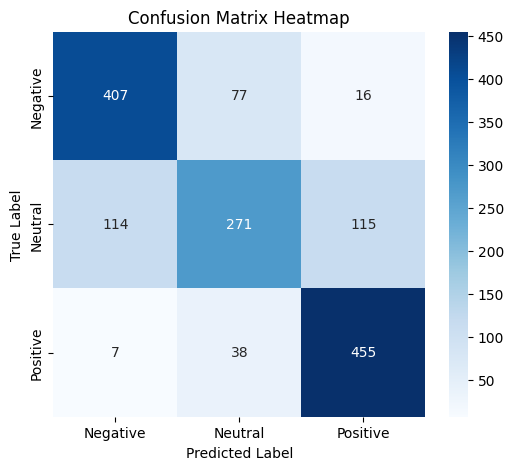

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define labels and confusion matrix
labels = ["Negative", "Neutral", "Positive"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
